In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import torch

In [27]:
class Value:
    def __init__(self,data, _children=(), _op = '', label = ''): 
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._grad = 0 
        self._backward = lambda: None

    def __repr__(self): #If this is not present, the values would be printed out in an ugly manner
        return f"Value(data = {self.data})"

    def __add__(self, other): # addition
        other = other if isinstance (other, Value) else Value(other) #converts the other number into a value class if not already done.
        out = Value(self.data + other.data, (self, other), '+') #adding and feeding the children and previous values

        def _backward():
            self._grad += 1.0 * out._grad
            other._grad += 1.0 * out._grad
            
        out._backward = _backward 
        return out

    def __radd__(self, other): #other + self
        return self + other

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

        
    def __mul__(self, other): #multiplication
        other = other if isinstance (other, Value) else Value(other) #converts the other number into a value class if not already done.
        out = Value(self.data * other.data, (self, other), '*') #adding and feeding the children and previous values
        
        def _backward():
            self._grad += other.data * out._grad
            other._grad += self.data  * out._grad
            
        out._backward = _backward
        return out

    def __rmul__(self, other): #other * self
        return self * other

    def __truediv__(self, other): #division (a x b^-1)
        return self * (other**-1)

    def exp(self): #exponent
        out = Value(math.exp(self.data), (self, ), 'exp')

        def _backward():
            self._grad +=  out.data * out._grad
        out._backward = _backward
        return out

    def __pow__(self, other): #power
        assert isinstance (other, (int, float)), "only supporting int and flaot powers"
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self._grad += (other * self.data**(other - 1)) * out._grad
        out._backward = _backward
        return out
        
    def tanh(self):
        out = Value((math.exp(self.data * 2) - 1) / (math.exp(self.data * 2) + 1), (self, ), 'tanh')
        
        def _backward():
            self._grad += (1 - out.data**2) * out._grad
            
        out._backward = _backward
        return out

    def backward(self):
        topo = [] #building a topo list
        visited = set() #building a visited set to keep track of which nodeshave already been visited.
        def build_topo(v):
            if v not in visited:
                visited.add(v) # adding in visited if the node has not already been visited
                for child in v._prev:
                    build_topo(child) # recursive function till the end
                topo.append(v) # adding the values in the topo list
        build_topo(self) # calling after the function is defined
    
        self._grad = 1.0 # setting the gradient of the farthest child node as 1 for calculating gradients
        for node in reversed(topo): # since the elements in the topo are in the reversed order (starting from basic inputs)
            node._backward() # calling every nodes' ._backward() function
            
# Children keeps track of what values produces what other values
# prev is a set that tracks of the previous values
# op keeps track of the operations' labels for the user to understand easily
# label helps us keep track of variable names 
# _backward keeps track of the input and output gradients so that it is useful to calculate every variable's gradients. The labda is set to None by default
'''
grad is used for gradient descents and differentiation
kept 0 which symbolises that gradient would not have an effect on the output value initially,
which is noramlly the case in backprop.
''' 

'''
for calculating gardients in an additon operation, we know that the gradients are simple passed down from the child node to the parent node.
therefore, defining a function for calculating backward propogation, _backward.
what this does is, it calculates the gradients for the two inputs by multiplying the data of the child (child.data) to 1.
because thats what it basically does hahaha.
'''

'''
for calculating gardients in an multiplication operation, we know that the gradients are simply the product of the data of their other equivalent node and the gradient of their child node.
therefore, defining a function for calculating backward propogation, _backward.
what this does is, it calculates the gradients for the two inputs by multiplying the data of the equivalent node (equivalent.data) to the child node gradient.
'''

'''
THERES A BUG HERE. Basically, we have been using variables that are used just once. therefore, their gradient was only taken into account for one time only.

but now if we have variables,  let's a and b and b = a + a. the analytical derivative of this would be 2 (db / da).
but our derivative function only counts it once. therefore, the gradients need to be accumulated at a place for further addition.

thus, we add and evaluate everybody's gradients. putting += in the ._backward function of every operation, instead of the traditional +
'''

"\nTHERES A BUG HERE. Basically, we have been using variables that are used just once. therefore, their gradient was only taken into account for one time only.\n\nbut now if we have variables,  let's a and b and b = a + a. the analytical derivative of this would be 2 (db / da).\nbut our derivative function only counts it once. therefore, the gradients need to be accumulated at a place for further addition.\n\nthus, we add and evaluate everybody's gradients. putting += in the ._backward function of every operation, instead of the traditional +\n"

In [28]:
from graphviz import Digraph

def trace(root):
    #builds a set of all the nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'}) #LR - left to right

    nodes, edges= trace(root)
    for n in nodes:
        uid = str(id(n))
        #for value in the graph, create a rectangular record for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n._grad), shape = 'record')

        if n._op:
            # if this value is a result of some operation, create a node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this with an edge
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connecting n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [29]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True #Tensors are n-dimensional arrays of scalars
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True #these tensors are of 1 element only. kinda like a matrix with a single element
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True #these tensors creates leaf nodes and the gradient is initially set to false by default
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o.data.item())
o.backward()

print("_________")
print("x1: ", x1.grad.item())
print("x2: ", x2.grad.item())
print("w1: ", w1.grad.item())
print("w2: ", w2.grad.item())

torch.Tensor([[1, 2, 3], [4, 5, 6]])

0.7071050214706146
_________
x1:  -1.500007465833125
x2:  0.5000024886110417
w1:  1.0000049772220834
w2:  0.0


tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [30]:
torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

torch.Size([2, 3])

In [31]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

# heading 2

BUILDING A NEURAL NETWORK. WITH TWO LAYERS OF 4 NEURONS EACH. 

In [70]:
class Neuron:

    def __init__(self, nin): # "nin" denotes the number of inputs that come into a neuron
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # weight - random between -1 and 1
        self. b = Value(random.uniform(-1, 1)) # base - random between -1 and 1

    def __call__(self, x): #dot product for weight and some array input x
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) # sums the products of weights and inputs one by one
        out = act.tanh() # output by having an activation function on the output of "weights x inputs + biases"
        return out

class Layer:

    def __init__(self, nin, nout): # nout is for the number of neurons we want in our layer
        self.neurons = [Neuron(nin) for _ in range(nout)] # creates a list of neurons

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # returns a list of data items if there are more than output neuron

class MLP: # Multi-layer perceptron aka neural network

    def __init__(self, nin, nouts): # "nouts" defines the sizes of all the layers in the neural network
        sz = [nin] + nouts # putting them all together
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # iterating over consecutive pairs and creating their layer

    def __call__(self,x):
        for layer in self.layers: #calls the layers and neurons sequentially
            x = layer(x)
        return x

In [71]:
x= [2.0, 3.0, 5.0] # creates the output for a single neuron
n = Neuron(3)
n(x)

Value(data = 0.9998831841682738)

In [72]:
x= [2.0, 3.0, 5.0] # creates the output for a layer of neuron
n = Layer(2,3)
n(x)

[Value(data = -0.9871705262720755),
 Value(data = 0.19074511372956376),
 Value(data = 0.747090094758723)]

SAY WE WANT A 3 INPUT, 2 LAYERS OF 4 NEURONS AND A SINGLE OUTPUT:

In [73]:
x = [4.0, 5.0, 9.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.8933730985167758)

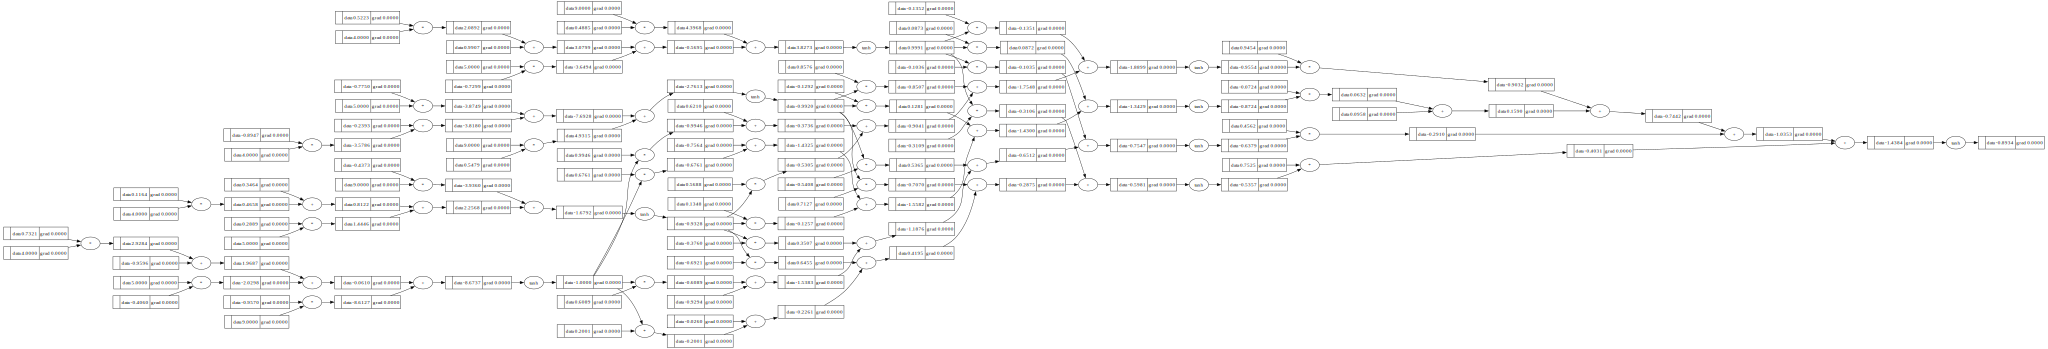

In [74]:
draw_dot(n(x))

NOW WE CODE FOR BACKPROPOGATION FOR THIS NN

LETS DO IT WITH THE HELP OF AN EXAMPLE. CREATNG RANDOM INPUTS AND DESIRING OUTPUTS. THEN TRAINING THE NEURAL NETWORK ON THEM.

In [107]:
xs = [
    [2.0, 8.0, 6.0],
    [5.0, 4.0, 6.5],
    [8.9, 9.1, 2.5], 
    [4.0, 8.9, 7.7]
]

ys = [1.0, 1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs] # predicting value from the neural network that we built
ypred


[Value(data = -0.8951707806405679),
 Value(data = -0.9137085996842034),
 Value(data = -0.7939125865213116),
 Value(data = -0.9205373888092633)]

CALCULATING LOSS WHICH SHOWS HOW GOOD OR ACCURATE OUR NEURAL NETWORK IS PERFORMING

In [111]:
[( yout - ytruth)**2 for ytruth, yout in zip(ys, ypred)] # using mean square root for calculating loss 

[Value(data = 3.59167228779378),
 Value(data = 3.6622806045052747),
 Value(data = 0.04247202199433588),
 Value(data = 3.6884638618143035)]

In [118]:
loss = sum(( yout - ytruth)**2 for ytruth, yout in zip(ys, ypred))
loss

Value(data = 10.984888776107693)

WE HAVE GOT TO MINIMIZE THE LOSS

In [119]:
loss.backward()

AND ITS DONE HAHAHA

In [121]:
n.layers[0].neurons[0].w[0]._grad 

1.0443383144065612

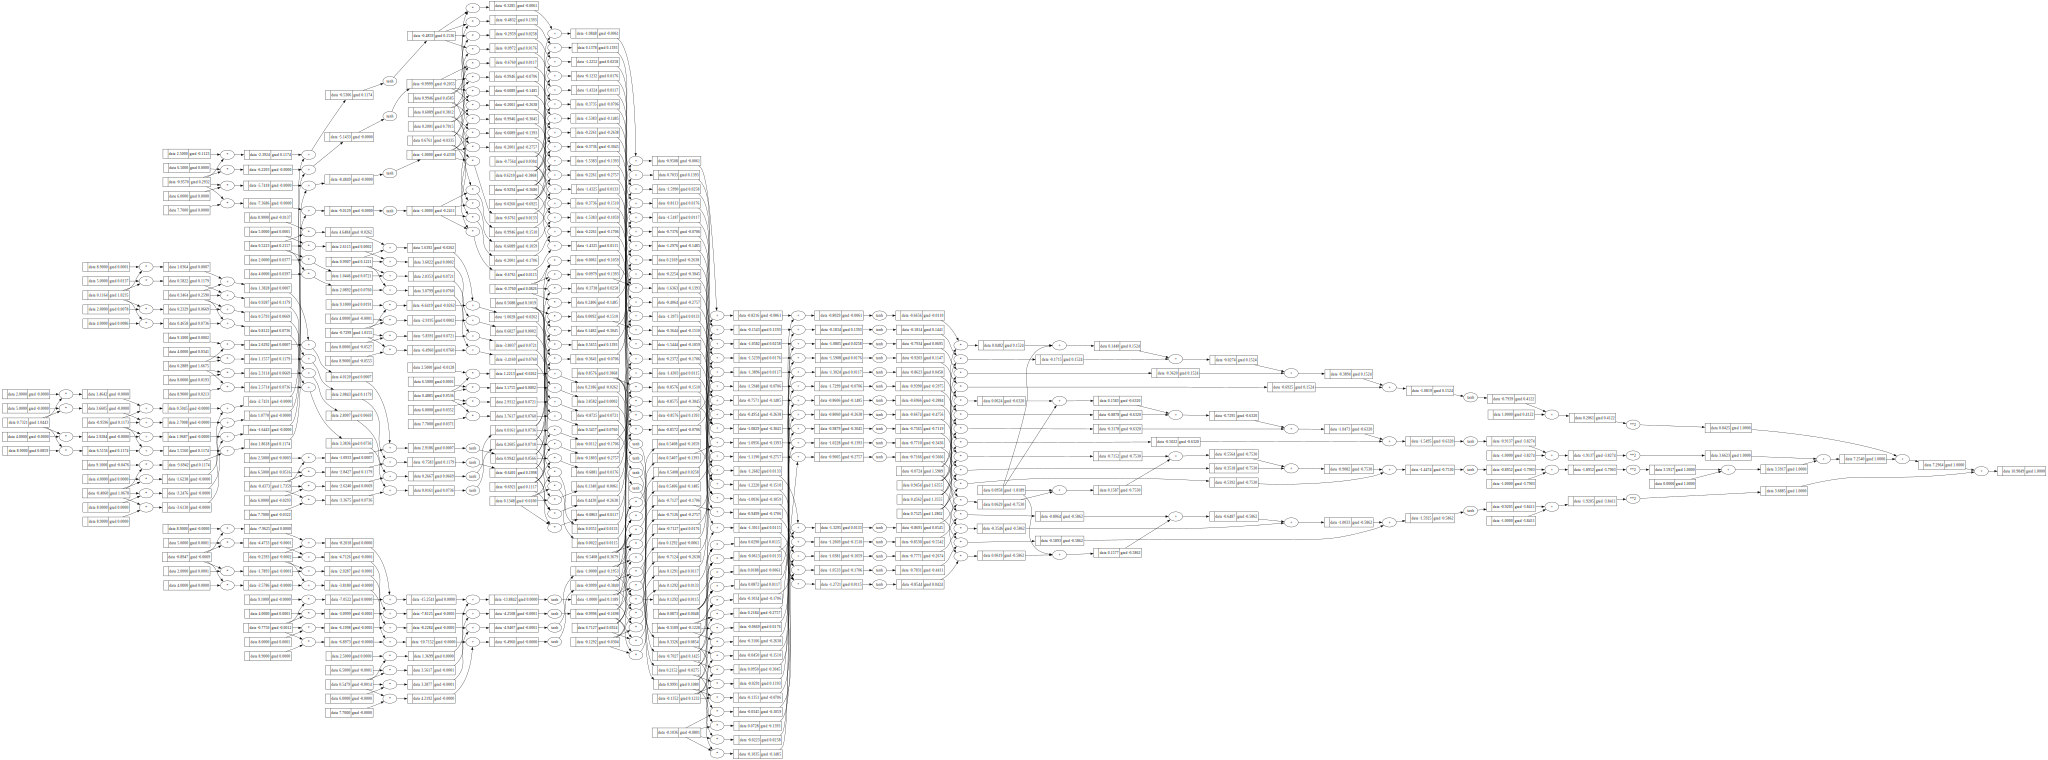

In [122]:
draw_dot(loss)

THEREFORE, WE HAVE CALCULATED GRADIENTS FOR ALL OF THE NEURONS. NOW WE JUST HAVE TO TWEAK THE WEIGHTS AND BIASES TO GET THE NEURAL NETWORK GIVE OUT THE DESIRED OUTPUTS

WE FIRST LIST OUT THE WEIGHTS AND BIASES ADN THEN TWEAK THEM IN THE DIRECTION OF GRADIENTS TO ACHIEVE THE DESIRED OUTPUT. 

THE CHANGES ARE DON BELOW

In [130]:
class Neuron:

    def __init__(self, nin): # "nin" denotes the number of inputs that come into a neuron
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # weight - random between -1 and 1
        self. b = Value(random.uniform(-1, 1)) # base - random between -1 and 1

    def __call__(self, x): #dot product for weight and some array input x
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) # sums the products of weights and inputs one by one
        out = act.tanh() # output by having an activation function on the output of "weights x inputs + biases"
        return out

    def parameters(self):
        return self.w + [self.b]  # returns a list of weights and biases of every neuron

class Layer:

    def __init__(self, nin, nout): # nout is for the number of neurons we want in our layer
        self.neurons = [Neuron(nin) for _ in range(nout)] # creates a list of neurons

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # returns a list of data items if there are more than output neuron

    def parameters(self):
        params = [] # returns the parameters of the layer on top of the parameters of neurons
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP: # Multi-layer perceptron aka neural network

    def __init__(self, nin, nouts): # "nouts" defines the sizes of all the layers in the neural network
        sz = [nin] + nouts # putting them all together
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # iterating over consecutive pairs and creating their layer

    def __call__(self,x):
        for layer in self.layers: #calls the layers and neurons sequentially
            x = layer(x)
        return x

    def parameters(self):
        params = [] # returns the parameters of the layer on top of the parameters of neurons
        for layer in self.layers:
            ls = layer.parameters()
            params.extend(ls)
        return params

In [132]:
x = [4.0, 5.0, 9.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.2122572849523045)

In [133]:
n.parameters()

[Value(data = 0.9793881720916742),
 Value(data = 0.7598751377776123),
 Value(data = -0.31854396731415524),
 Value(data = -0.5970193165418654),
 Value(data = -0.8846503329248077),
 Value(data = 0.5195651516860735),
 Value(data = 0.25598727970393464),
 Value(data = -0.74482486870594),
 Value(data = 0.46421864351447084),
 Value(data = 0.7931880638453139),
 Value(data = -0.7801804576565514),
 Value(data = 0.6419523116846468),
 Value(data = 0.4606888191539018),
 Value(data = 0.43502054864627127),
 Value(data = 0.2996488751323776),
 Value(data = -0.3066351830334937),
 Value(data = -0.5433552827213086),
 Value(data = 0.6906320047473586),
 Value(data = -0.8905048892779148),
 Value(data = -0.11463049160564309),
 Value(data = -0.5491696549684038),
 Value(data = -0.4507254011621047),
 Value(data = -0.27844825014433616),
 Value(data = -0.8793286117783699),
 Value(data = 0.1864986923085299),
 Value(data = 0.26563515571609875),
 Value(data = -0.6214955389502594),
 Value(data = -0.3714151166839794),


In [134]:
len(n.parameters())

41

In [135]:
xs = [
    [2.0, 8.0, 6.0],
    [5.0, 4.0, 6.5],
    [8.9, 9.1, 2.5], 
    [4.0, 8.9, 7.7]
]

ys = [1.0, 1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs] # predicting value from the neural network that we built
ypred


[Value(data = 0.3641960645961758),
 Value(data = 0.3084214386923744),
 Value(data = 0.44916566399615837),
 Value(data = 0.36407611918838856)]

In [136]:
loss = sum(( yout - ytruth)**2 for ytruth, yout in zip(ys, ypred))
loss

Value(data = 3.387007854627243)

In [137]:
loss.backward()

In [140]:
n.layers[0].neurons[0].w[0]._grad

0.0002487697268856343

In [142]:
n.layers[0].neurons[0].w[0].data

0.9793881720916742

NOW TO UPDATE EVERY VALUE OF THE PARAMETERS:

In [144]:
for  parameter in n.parameters():
    parameter.data += -0.1 * parameter._grad

HERE, TRADITIONALLY INCREASING THE DATA MAKES THE LOSS GO UP. AND THUS INCREASING THE LOSS WHICH IN TURN IS WHAT WE DONT WANT

THEREFROE, ADDING A NEGATIVE SIGN SO THAT IT DECREASES THE LOSS AND RETURNS TEH DESIRED OUTPUT

# heading 3

we can think of it like the vectors of teh gradients points towards increasing the loss, but we want to decrease it and therefore, go into the opposite direction.

therefore, adding the negative sign

In [146]:
n.layers[0].neurons[0].w[0].data # the data is decreased which is exactly what we wanted. moving in the direction opposite to the gradient. (cell 140 output)

0.9793632951189856

In [147]:
ypred = [n(x) for x in xs]
loss = sum(( yout - ytruth)**2 for ytruth, yout in zip(ys, ypred))
loss

Value(data = 2.7414381360271034)

In [148]:
ypred

[Value(data = 0.8028715002698462),
 Value(data = 0.5994514636140947),
 Value(data = 0.581996281672306),
 Value(data = 0.8014373514596747)]

THERE IS A SIGNIFICANT DECREASE IN THE LOSS

# heading 3

NOW, ALL THATS LEFT TO DO IS TO CALCULATE THE FORWARD PASS, CALCULATE BACKWARD PROPOGATION AND NUDGE THE PARAMETERS.

AND REPEAT. REPEAT. REPEAT.

In [154]:
xs = [
    [2.0, 8.0, 6.0],
    [5.0, 4.0, 6.5],
    [8.9, 9.1, 2.5], 
    [4.0, 8.9, 7.7]
]

ys = [1.0, 1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]

In [156]:
ypred

[Value(data = 0.9778699206177647),
 Value(data = 0.9778012727583907),
 Value(data = 0.9778625684031174),
 Value(data = 0.9778656715499576)]

In [162]:
x = [4.0, 5.0, 9.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = 0.8717038509048238)

In [176]:
for k in range (100):
    
    #forward
    ypred = [n(x) for x in xs]
    loss = sum(( yout - ytruth)**2 for ytruth, yout in zip(ys, ypred))

    #backward
    for parameter in n.parameters():
        parameter._grad = 0.0
    loss.backward()

    #update
    for parameter in n.parameters():
        parameter.data += -0.1 * parameter._grad

    print(k, loss.data)

0 0.003600878297609368
1 0.0035636066659220757
2 0.0035270837453453686
3 0.003491287361118465
4 0.003456196202282811
5 0.0034217897801255446
6 0.003388048388995454
7 0.0033549530693348607
8 0.003322485572782999
9 0.0032906283292165406
10 0.003259364415603518
11 0.0032286775265551165
12 0.0031985519464686305
13 0.0031689725231621225
14 0.0031399246429087923
15 0.0031113942067849147
16 0.00308336760825172
17 0.0030558317118967475
18 0.0030287738332655323
19 0.0030021817197187148
20 0.0029760435322546803
21 0.0029503478282411973
22 0.002925083545003607
23 0.0029002399842205655
24 0.0028758067970811796
25 0.0028517739701607917
26 0.0028281318119750846
27 0.0028048709401749866
28 0.0027819822693467434
29 0.0027594569993845955
30 0.0027372866044044963
31 0.0027154628221700027
32 0.002693977644003048
33 0.0026728233051536167
34 0.0026519922756044188
35 0.002631477251287759
36 0.0026112711456932696
37 0.002591367081846206
38 0.0025717583846376485
39 0.002552438573488545
40 0.002533401355330891

In [177]:
ypred

[Value(data = 0.9830153416784535),
 Value(data = 0.9825351028711475),
 Value(data = -0.9704498572711125),
 Value(data = 0.9830167734036886)]